# ディープラーニングでスキー／スノーボードの画像識別をやってみた
### 参考にしたURL: https://qiita.com/kimkim42/items/0790786bf1bd39e32af3

# 準備

### 1. 画像のダウンロード(Yahoo画像検索APIを使用，max60枚/1検索らしい)
- 参考URLの get_images.py を流用
- 例) python get_images.py スキー
  - スキーをキーワードに画像を検索し"スキー"フォルダに格納
- 目的に合わない／学習に不適な画像も多いので，手作業で選別(これが面倒)

### 2. 画像読み込み，画像データリストファイル作成
#### JPG画像は，分類クラス毎のフォルダ配下に格納され，1.jpg, 2.jpg,...のように連番のファイル名になっている前提
- 画像データリストファイルには，画像データのパスと分類クラスのラベル(例:ski→0, snowboard→1など)が書かれる
- ファイル配置の例)
  - img_data/ski/1.jpg, 2.jpg, 3.jpg,...
  - img_data/snowboard/1.jpg, 2.jpg, 3.jpg,...

In [1]:
import os

FILENAME_IMG_LIST = "image_label_list.txt"
COUNT_MAX = 200

# スキー画像の格納先，分類ラベル
DIR_IMG_LB0   = "img_data/ski/"
LABEL_IMG_LB0 = "0"

# スノーボード画像の格納先，分類ラベル
DIR_IMG_LB1   = "img_data/snowboard/"
LABEL_IMG_LB1 = "1"

with open(FILENAME_IMG_LIST, "w") as file :

    for count in range(0, COUNT_MAX) :
        file_name = DIR_IMG_LB0 + str(count) + ".jpg"
        if(os.path.exists(file_name)):
            file.write(DIR_IMG_LB0 + str(count) + ".jpg" + " " + LABEL_IMG_LB0 + "\n")
        count += 1
        
    for count in range(0, COUNT_MAX) :
        file_name = DIR_IMG_LB1 + str(count) + ".jpg"
        if(os.path.exists(file_name)):
            file.write(DIR_IMG_LB1 + str(count) + ".jpg" + " " + LABEL_IMG_LB1 + "\n")
        count += 1

# 画像識別

In [2]:
import random
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt 

CHANNELS = 3    # 画像カラー 1→白黒，3→RGB
NUM_CLASSES = 2    # 分類クラス数(=ラベル数)
IMAGE_SIZE = 56    # 画像の変換後のサイズ(縦横同じ)
IMAGE_MATRIX_SIZE = IMAGE_SIZE * IMAGE_SIZE * CHANNELS    # 画像1つの配列サイズ(=入力データのノード数)

## 画像リストを元に画像読み込み，学習・テストデータ作成

### リスト情報読み込み，ランダムに並べ替え

In [3]:
IMG_LBL_LIST = []

with open(FILENAME_IMG_LIST, mode='r') as file :

    for line in file :
        # 改行を除く
        line = line.rstrip()
        # スペースで区切られたlineを、配列にする
        line_list = line.split()
        IMG_LBL_LIST.append(line_list)
        random.shuffle(IMG_LBL_LIST)

# 確認用
#for img in IMG_LBL_LIST: print(img)

### 画像読み込み，サイズ変更，データ格納

In [4]:
DATA_SET = []

for img_lbl in IMG_LBL_LIST :

    tmp_data = []

    # 画像を読み込み、サイズを変更する
    img = cv2.imread(img_lbl[0])
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
      
    # 行列を一次元に、dtypeをfloat32に、０〜１の値に正規化する
    img = img.flatten().astype(np.float32)/255.0

    # 分類するクラス数の長さを持つラベル用配列
    classes_array = np.zeros(NUM_CLASSES, dtype = 'float64')
    # ラベルの値に対応する配列要素を1にする
    classes_array[int(img_lbl[1])] = 1

    tmp_data.append(img)
    tmp_data.append(classes_array)
    tmp_data.append(img_lbl[0])
    
    DATA_SET.append(tmp_data)

### 学習データとテストデータに分割

In [5]:
RATIO_TRAIN_DATA = 0.8
    
print("全データ数\t", int(len(DATA_SET)))
TRAIN_DATA_SIZE = int(len(DATA_SET) * RATIO_TRAIN_DATA)

TRAIN_DATA_SET = DATA_SET[:TRAIN_DATA_SIZE]
print("学習データ数\t", int(len(TRAIN_DATA_SET)))

TEST_DATA_SET = DATA_SET[TRAIN_DATA_SIZE:]
print("テストデータ数\t", int(len(TEST_DATA_SET)))

全データ数	 41
学習データ数	 32
テストデータ数	 9


### 関数定義

In [6]:
# バッチデータをランダムに選択

def batch_data(data_set, batch_size) :

    data_set = random.sample(data_set, batch_size)

    return data_set

In [7]:
# バッチデータを，画像データと分類ラベルに分割

def devide_data_set(data_set) :
    data_set = np.array(data_set)
    image_data_set = data_set[:int(len(data_set)), :1].flatten()
    label_data_set = data_set[:int(len(data_set)), 1:2].flatten()

    image_ndarray = np.empty((0, IMAGE_MATRIX_SIZE))
    label_ndarray = np.empty((0, NUM_CLASSES))

    for (img, label) in zip(image_data_set, label_data_set) :
        image_ndarray = np.append(image_ndarray, np.reshape(img, (1, IMAGE_MATRIX_SIZE)), axis=0)
        label_ndarray = np.append(label_ndarray, np.reshape(label, (1, NUM_CLASSES)), axis=0)

    return image_ndarray, label_ndarray

In [8]:
# 畳み込み
# tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, name=None)
# https://qiita.com/tadOne/items/b484ce9f973a9f80036e

def conv2d(x, W) :
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [9]:
# プーリング(画像の縮小)
# https://qiita.com/mine820/items/03e2bbd9b603383486e0

def max_pool_2x2(x) :
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [10]:
# 重み変数の初期値設定(正規分布，標準偏差)
# https://qiita.com/supersaiakujin/items/464cc053418e9a37fa7b

def weight_variable(shape) :
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [11]:
# バイアス変数の初期値設定(定数)

def bias_variable(shape) :
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### ニューラルネット定義

In [12]:
def deepnn(x) :

    with tf.name_scope('reshape') :
        x_image = tf.reshape(x, [-1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS])

    with tf.name_scope('conv1') :
        W_conv1 = weight_variable([5, 5, CHANNELS, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    with tf.name_scope('pool1') :
        h_pool1 = max_pool_2x2(h_conv1)

    with tf.name_scope('conv2') :
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    with tf.name_scope('pool2') :
        h_pool2 = max_pool_2x2(h_conv2)        

# 元画像サイズを28→56に大きくしたので，畳み込みを3層に変更
    with tf.name_scope('conv3') :
        W_conv3 = weight_variable([5, 5, 64, 64])
        b_conv3 = bias_variable([64])
        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)

    with tf.name_scope('pool3') :
        h_pool3 = max_pool_2x2(h_conv3)   
# ここまで
        
    with tf.name_scope('fc1') :
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])

        #h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        #h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        
        h_pool3_flat = tf.reshape(h_pool3, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
        
    with tf.name_scope('dropout') :
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    with tf.name_scope('fc2') :
        W_fc2 = weight_variable([1024, NUM_CLASSES])
        b_fc2 = bias_variable([NUM_CLASSES])

        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    return y_conv, keep_prob

### テストデータの正解ラベル，推定値の表示

In [13]:
LABEL_NAME_LB0 = "SKI"
LABEL_NAME_LB1 = "SNB"

def test_result(pred, test_label):
    print("No.\t正解\t推定\t判定\t\t正解ラベル\t推定クラス")
    
    i = 0
    for i in range(int(len(test_label))):

        if test_label[i][int(LABEL_IMG_LB0)] == 1:
            ans = LABEL_NAME_LB0
        elif test_label[i][int(LABEL_IMG_LB1)] == 1:
            ans = LABEL_NAME_LB1
          
        if pred[i] == int(LABEL_IMG_LB0):
            prd = LABEL_NAME_LB0
        elif pred[i] == int(LABEL_IMG_LB1):
            prd = LABEL_NAME_LB1
            
        if ans == prd :
            result = "OK"
        else:
            result = "NG"
            
        print(i+1, '\t',ans, '\t',prd, '\t',result, '\t\t', test_label[i], '\t',pred[i])

        i+=1

## 学習・テスト実行

In [14]:
MAX_EPOCH  = 360    # エポック数
BATCH_SIZE = 30     # バッチサイズ

def main(_):

# 入力・出力のプレースホルダ

    x = tf.placeholder(tf.float32, [None, IMAGE_MATRIX_SIZE])

    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    y_conv, keep_prob  = deepnn(x)

# 損失関数，最適化アルゴリズム，評価関数

    with tf.name_scope('loss'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)

    with tf.name_scope('adam_optimizer'):
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

# 学習ループ

    with tf.Session() as sess :
        sess.run(tf.global_variables_initializer())

        !date
        
        print('エポック数'+'\t'+'正解率(学習データ)%'+'\t'+'正解率(テストデータ)%')
        
        for epoch_step in range(MAX_EPOCH) :

            # 教師データ(バッチ)の読み込み，画像・正解ラベル分割
            train_data_set = batch_data(TRAIN_DATA_SET, BATCH_SIZE)
            train_image, train_label = devide_data_set(train_data_set)

            # テスト(周期)
            if epoch_step % BATCH_SIZE == 0 :
                
                # 学習データでの正解率
                train_accuracy = accuracy.eval(feed_dict={x: train_image, y_: train_label, keep_prob: 1.0})
                #print('epoch_step %d, training accuracy %g' % (epoch_step, train_accuracy))
                #print(' train accuracy %g' % train_accuracy)
                
                # テストデータでの正解率
                test_image, test_label = devide_data_set(TEST_DATA_SET)
                test_accuracy = accuracy.eval(feed_dict={x: test_image, y_: test_label, keep_prob: 1.0})

                print(('%d'+'\t'+'%3.0f'+'\t'+'%3.0f') % (epoch_step, train_accuracy*100.0, test_accuracy*100.0))

            # 学習の実行
            train_step.run(feed_dict={x: train_image, y_: train_label, keep_prob: 0.5})

        # テストデータでの正解率:最終
        test_image, test_label = devide_data_set(TEST_DATA_SET)
        test_accuracy = accuracy.eval(feed_dict={x: test_image, y_: test_label, keep_prob: 1.0})
        print(('%d'+'\t'+'%3.0f'+'\t'+'%3.0f') % (epoch_step, train_accuracy*100.0, test_accuracy*100.0))

        !date

        # 正誤判定
        pred = sess.run(tf.argmax(y_conv, 1), feed_dict={x: test_image, y_: test_label, keep_prob: 1.0})
        test_result(pred, test_label)
        
if __name__ == '__main__' :
    main(_)

2018年  4月 19日 木曜日 23:43:37 JST
エポック数	正解率(学習データ)%	正解率(テストデータ)%
0	 57	 78
30	 83	100
60	100	100
90	100	100
120	100	100
150	100	100
180	100	100
210	100	100
240	100	100
270	100	100
300	100	100
330	100	100
359	100	100
2018年  4月 19日 木曜日 23:47:12 JST
No.	正解	推定	判定		正解ラベル	推定クラス
1 	 SKI 	 SKI 	 OK 		 [ 1.  0.] 	 0
2 	 SKI 	 SKI 	 OK 		 [ 1.  0.] 	 0
3 	 SKI 	 SKI 	 OK 		 [ 1.  0.] 	 0
4 	 SKI 	 SKI 	 OK 		 [ 1.  0.] 	 0
5 	 SNB 	 SNB 	 OK 		 [ 0.  1.] 	 1
6 	 SKI 	 SKI 	 OK 		 [ 1.  0.] 	 0
7 	 SKI 	 SKI 	 OK 		 [ 1.  0.] 	 0
8 	 SNB 	 SNB 	 OK 		 [ 0.  1.] 	 1
9 	 SKI 	 SKI 	 OK 		 [ 1.  0.] 	 0


### 学習・テストデータの画像確認

In [15]:
# サイズ変更後の画像表示(確認用)
import math

AREA_WIDTH      = 16
AREA_HIGHT_UNIT = 3
NUM_COL         = 6
NUM_ROW         = int(math.ceil(len(IMG_LBL_LIST) / float(NUM_COL) )) 

def img_subplot(data, NUM_ROW, NUM_COL, n):
    show_img = cv2.cvtColor(data[0].reshape(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), cv2.COLOR_BGR2RGB)
    plt.subplot(NUM_ROW, NUM_COL, n)
    plt.title(str(n )+ ":" + str(data[2]))
    plt.axis("off")
    plt.imshow(show_img) 

### 学習データ

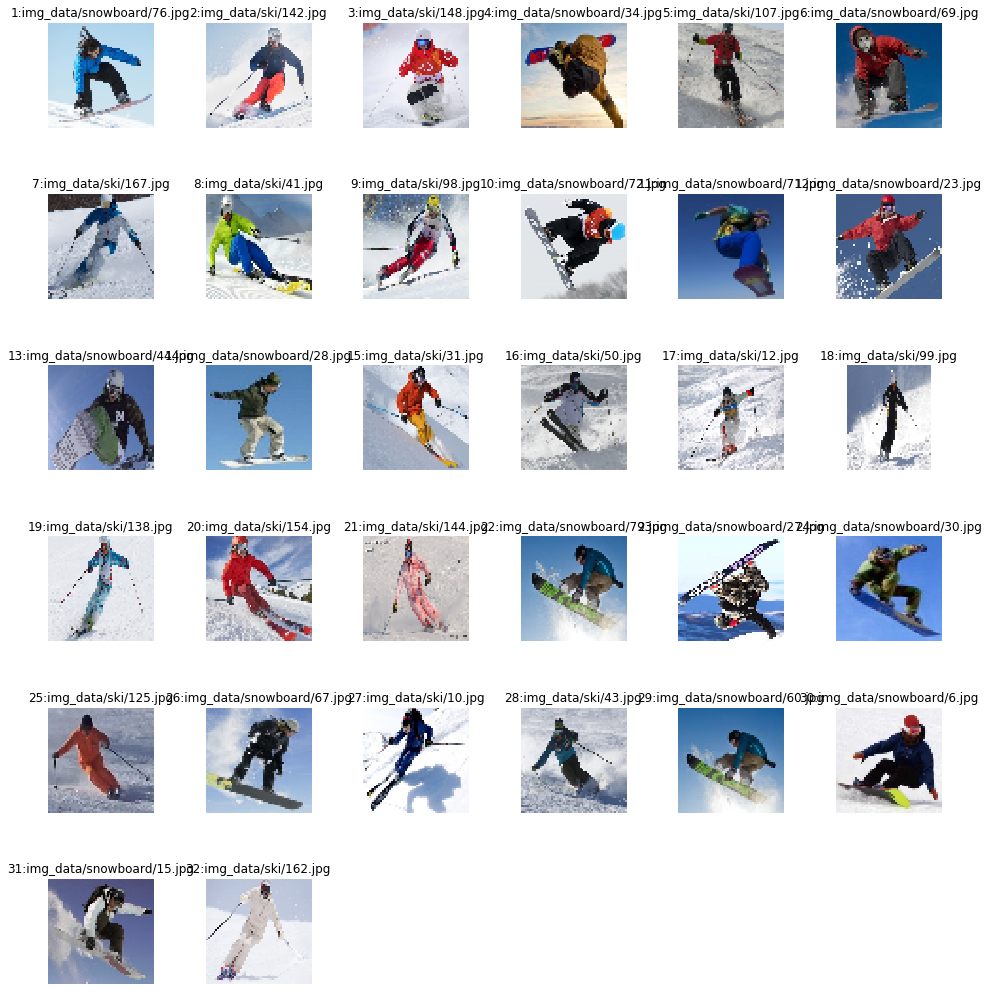

In [16]:
plt.figure(figsize=(AREA_WIDTH , AREA_HIGHT_UNIT*NUM_ROW))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
n=1
for data in DATA_SET[:TRAIN_DATA_SIZE]:
    img_subplot(data, NUM_ROW, NUM_COL, n)
    n+=1
plt.show()

### テストデータ

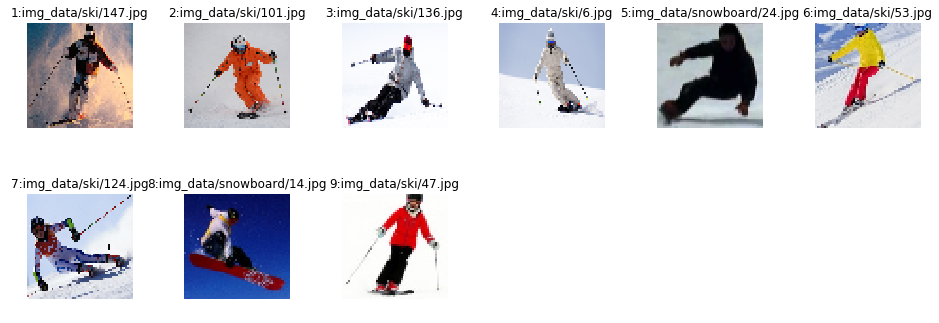

In [17]:
plt.figure(figsize=(AREA_WIDTH , AREA_HIGHT_UNIT*NUM_ROW))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
n=1
for data in DATA_SET[TRAIN_DATA_SIZE:]:
    img_subplot(data, NUM_ROW, NUM_COL, n)
    n+=1
plt.show()

# 考察

### 結果:たかだか30枚の画像×300回程度の学習で，正解率100%

- 最初，200枚位の画像×1000回の学習でやったら，正解率60%位しかいかなかった
  - 200枚の画像を選ぶ際も，スキー・スノボの板だけの写真や複数人が写っている写真などは手作業で除外．まずこれが面倒...
  - 特徴を抽出しきれず，紛らわしい画像を識別できていないと予想
- スキー/スノボのフォームの違いの特徴は何か？を考えてみる
  - スキー:両手を広げている，ストックを持っている，体は比較的真っ直ぐ，脚を開いていない(膝が付いている)．つまり，矢印(↑)みたいなシルエット．
  - スノボ:グラブしている(片手しか見えていない)，体は畳んでいる，膝が空いている．つまり，三角形(△)から線が1本出ているみたいなシルエット．
- この特徴を元に，紛らわしい画像(例えばスキーなのに片手しか見えていない／脚が開いている)を除外していったところ，正解率アップ

- しかし本来は，このような恣意的なデータスクリーニングをせずに，大量のデータで学習させて識別できるようにすべき
  - 結局のところ，そんな大量のデータを集めて正解ラベル付けするのが一番大変...